# Parking Lot Diagram
In this notebook, we'll using the OpenCV (`cv2`) Python library to capture the lines of the parking lot as well as representing the empty spaces as rectangles.

## Notebook Setup

In [1]:
# Importing the necessary Python libraries
import cv2
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
# Loading in the raw parking lot image
raw_img = cv2.imread('../data/raw/empty_parking_lot.jpeg')

# Color correcting the image from BGR to RGB
raw_img = cv2.cvtColor(raw_img, cv2.COLOR_BGR2RGB)

# Converting the image to grayscale
gray_img = cv2.cvtColor(raw_img, cv2.COLOR_RGB2GRAY)

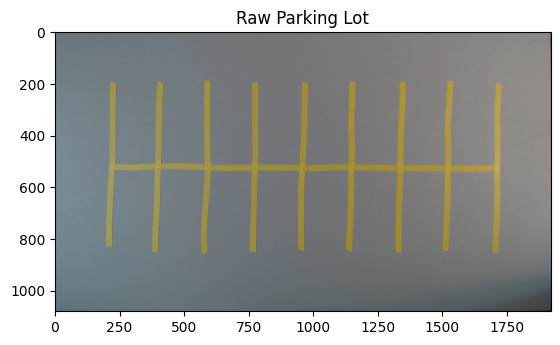

In [3]:
# Viewing the raw parking lot
plt.title('Raw Parking Lot')
plt.imshow(raw_img);

## Masking on the Yellow Color

Because we know our parking lot has distinct yellow lines, we can create a **mask** that looks specifically just for that yellow-like color. In order to do this, we'll need to use an HSV version of the image, which you might recall we had to use in our image processing notebook for color equalization. Since we have to do this anyway, I'm going to go ahead and apply a color equalization to make that color really pop.

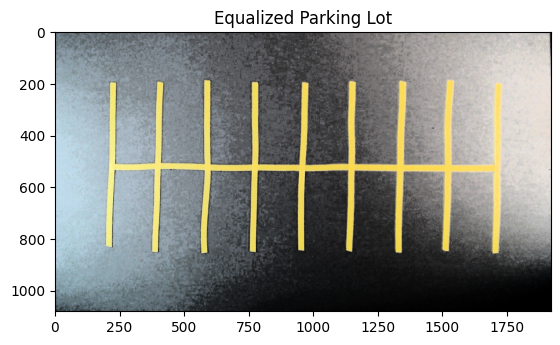

In [4]:
# Converting our raw parking lot image from its current RGB to HSV
hsv_img = cv2.cvtColor(raw_img, cv2.COLOR_RGB2HSV)

# Applying the color equalization to the HSV image
hsv_img[:, :, 2] = cv2.equalizeHist(hsv_img[:, :, 2])

# Converting the image from HSV to RGB for display purposes
equalized_img = cv2.cvtColor(hsv_img, cv2.COLOR_HSV2RGB)

# Displaying the equalized parking lot
plt.title('Equalized Parking Lot')
plt.imshow(equalized_img);

Now, we have this image that is really distinct in terms of that yellow color compared to the rest of the image. What we're going to do now is create lower and upper bounds that generally represent the yellow color, and then we're going to create this mask from the HSV image that will only grab that yellow color

In [5]:
# Defining the lower and upper bounds for the yellow mask
lower_yellow = np.array([22, 93, 0], dtype = 'uint8')
upper_yellow = np.array([45, 255, 255], dtype = 'uint8')

In [6]:
# Extracting the parking lot lines our yellow mask boundaries and HSV image
parking_lines = cv2.inRange(hsv_img, 
                            lowerb = lower_yellow,
                            upperb = upper_yellow)

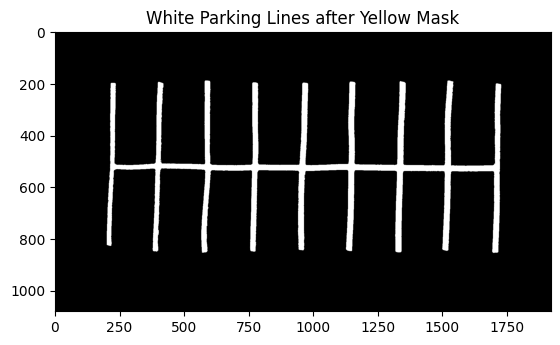

In [7]:
# Displaying the parking lines after applying the yellow mask
plt.title('White Parking Lines after Yellow Mask')
plt.imshow(parking_lines, cmap = 'gray');

In [8]:
contours, hierarchy = cv2.findContours(parking_lines, 
                                       mode = cv2.RETR_EXTERNAL, 
                                       method = cv2.CHAIN_APPROX_NONE)

In [9]:
p_lines = parking_lines.copy()

In [10]:
cv2.drawContours(p_lines, contours, -1, (0, 255, 0), 3)

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

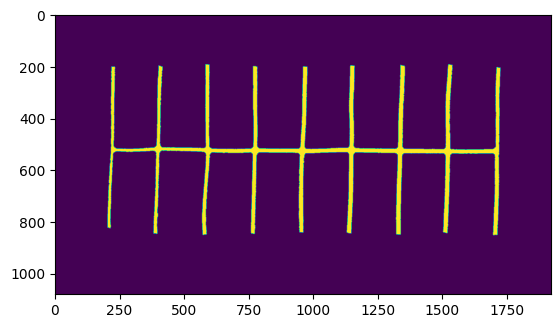

In [11]:
plt.imshow(p_lines)

In [12]:
x, y, w, h = cv2.boundingRect(parking_lines)

In [13]:
print(f'{x}, {y}, {w}, {h}')

200, 190, 1524, 666


In [14]:
left = (x, np.argmax(parking_lines[:, x]))            
right = (x+w-1, np.argmax(parking_lines[:, x+w-1]))    
top = (np.argmax(parking_lines[y, :]), y)              
bottom = (np.argmax(parking_lines[y+h-1, :]), y+h-1) 

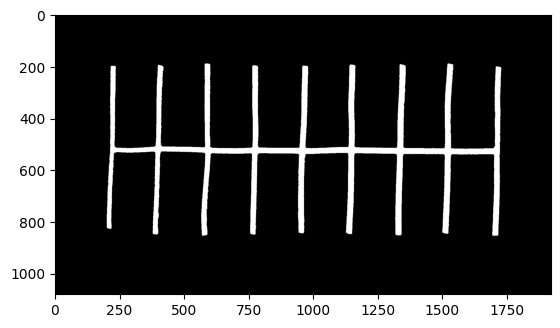

In [15]:
plt.imshow(parking_lines, cmap = 'gray')

In [16]:
p_lines = cv2.cvtColor(parking_lines, cv2.COLOR_GRAY2RGB)

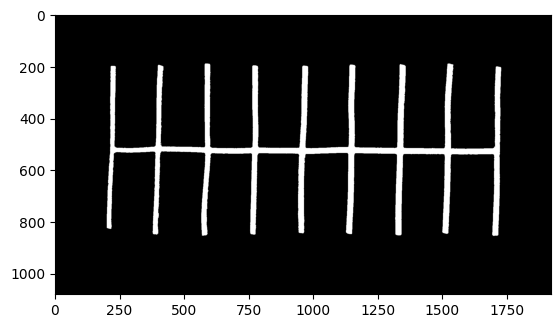

In [17]:
plt.imshow(p_lines)

In [18]:
x, y, w, h = cv2.boundingRect(parking_lines)

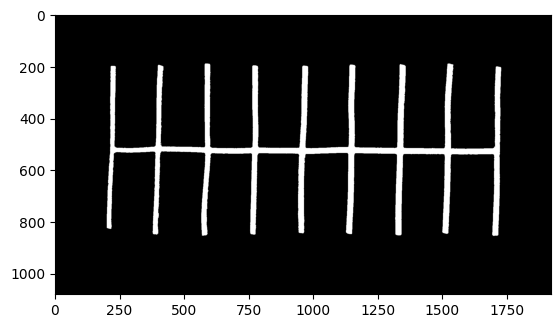

In [19]:
plt.imshow(p_lines)

In [20]:
cv2.rectangle(p_lines, pt1 = (x, y),
              pt2 = (x + w, y + h), color = (255, 255, 255),
              thickness = 50)

array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)

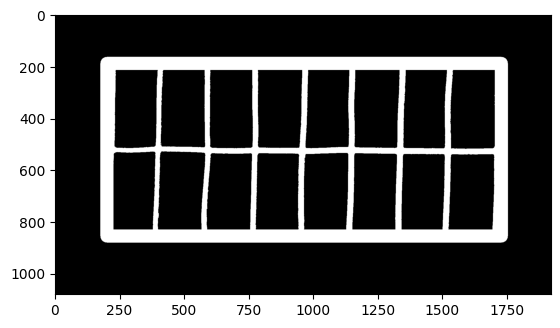

In [21]:
plt.imshow(p_lines)

In [22]:
p_lines = cv2.cvtColor(p_lines, cv2.COLOR_RGB2GRAY)

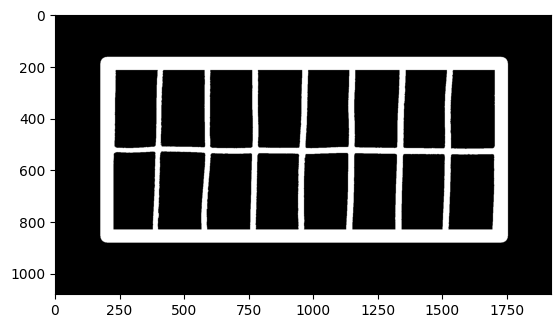

In [23]:
plt.imshow(p_lines, cmap = 'gray');

In [24]:
p_lines_inverted = cv2.bitwise_not(p_lines)

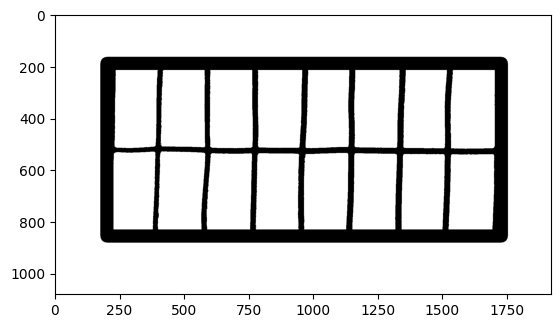

In [25]:
plt.imshow(p_lines_inverted, cmap = 'gray');

In [26]:
roi = p_lines[y:y + h, x: x + w]

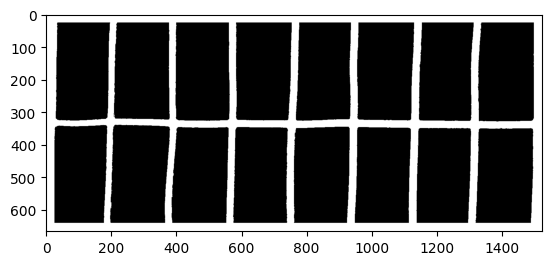

In [27]:
plt.imshow(roi, cmap = 'gray')

In [28]:
parking_spaces = np.ones(p_lines_inverted.shape, dtype = np.uint8) * 255

In [29]:
parking_spaces[y: y + h, x: x + w] = roi

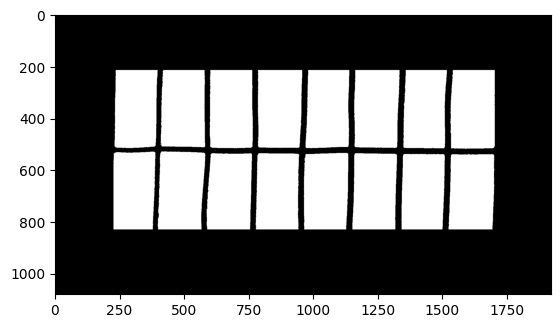

In [30]:
parking_spaces = cv2.bitwise_not(parking_spaces)
plt.imshow(parking_spaces, cmap = 'gray')

In [31]:
ret, markers = cv2.connectedComponents(parking_spaces)

In [32]:
ret

18

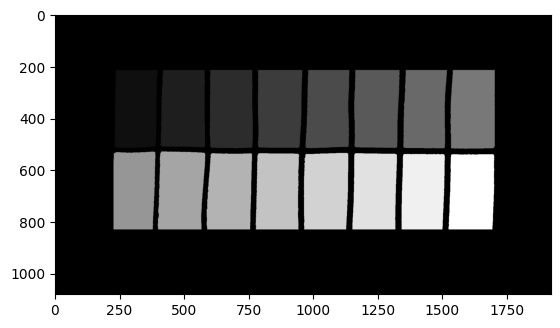

In [33]:
plt.imshow(markers, cmap = 'gray')

In [34]:
# Creating a custom kernel using Numpy's "ones" function
kernel = np.ones((7, 7), dtype = np.uint8)

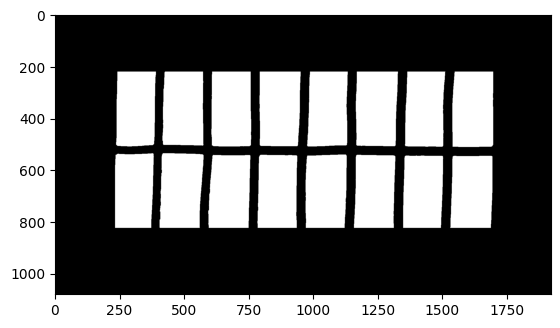

In [35]:
eroded_spaces = cv2.erode(parking_spaces,
                          kernel = kernel,
                          iterations = 2)

plt.imshow(eroded_spaces, cmap = 'gray')

In [36]:
contours, hierarchy = cv2.findContours(eroded_spaces,
                                       cv2.RETR_EXTERNAL,
                                       cv2.CHAIN_APPROX_SIMPLE)

In [37]:
len(contours)

16

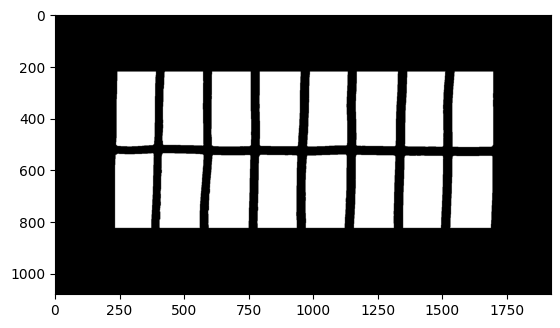

In [38]:
draft = cv2.cvtColor(eroded_spaces, cv2.COLOR_GRAY2RGB)
plt.imshow(draft)

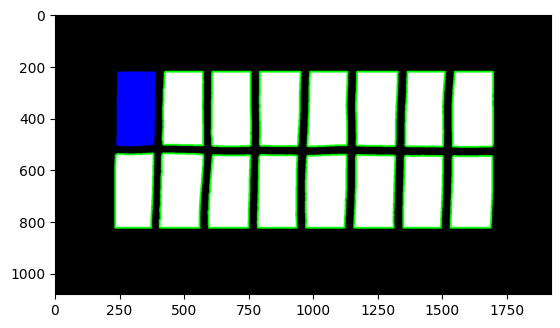

In [39]:
for c in contours:
    
    result = cv2.pointPolygonTest(c, (275, 400), False)

    if result == 1:
        cv2.drawContours(draft, [c], -1, (0, 0, 255), -1)
    else:
        cv2.drawContours(draft, [c], -1, (0, 255, 0), 5)
    
plt.imshow(draft)

In [40]:
img = raw_img.copy()

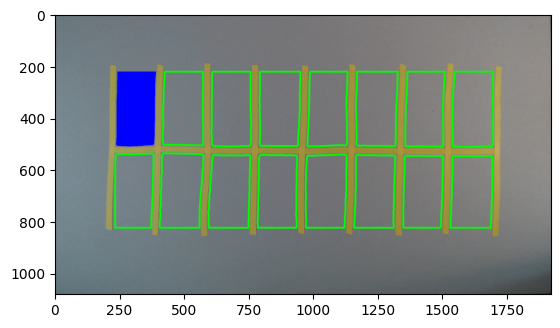

In [41]:
for c in contours:
    
    result = cv2.pointPolygonTest(c, (275, 400), False)

    if result == 1:
        cv2.drawContours(img, [c], -1, (0, 0, 255), -1)
    else:
        cv2.drawContours(img, [c], -1, (0, 255, 0), 5)
    
plt.imshow(img)